In [2]:
import random
import math
import torch
import torch.nn as nn
import torch.fft
from functools import partial
from torch.nn.init import trunc_normal_
from timm.models.layers import DropPath

import torch.nn as nn
import torch.optim as optim
import torch.fft
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
from collections import defaultdict
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Mounted at /content/drive


In [8]:
!rsync -a /content/drive/MyDrive/3007/Archive/ASL_Dataset /content/

rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at rsync.c(716) [sender=3.2.7]
rsync: [generator] write error: Broken pipe (32)
rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at io.c(519) [receiver=3.2.7]
rsync: connection unexpectedly closed (220583 bytes received so far) [generator]


In [22]:
import os, random, torch
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets, transforms
from torchvision.transforms import v2


preprocess = v2.Compose([

    v2.Grayscale(num_output_channels=1),

    v2.RandomRotation(degrees=15),

    v2.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    v2.RandomPerspective(distortion_scale=0.2, p=0.5),

    v2.ColorJitter(brightness=0.2, contrast=0.2),

    v2.Resize((96, 96)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
]).to("cuda")

val_process = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((96, 96)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
]).to("cuda")

root = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Train'
full_ds = datasets.ImageFolder(root, transform=preprocess)

class FewShotBalancedSampler(Sampler):
    def __init__(self, targets, k_per_class, generator=None):
        self.targets = torch.as_tensor(targets)
        self.classes = torch.unique(self.targets)
        self.k = k_per_class
        self.generator = generator or torch.Generator()

    def __iter__(self):

        idxs = []
        g = self.generator
        for c in self.classes:
            cls_idxs = (self.targets == c).nonzero(as_tuple=True)[0]

            perm = torch.randperm(len(cls_idxs), generator=g)[:self.k]
            idxs.extend(cls_idxs[perm].tolist())
        random.shuffle(idxs)
        return iter(idxs)

    def __len__(self):
        return len(self.classes) * self.k

sampler = FewShotBalancedSampler(full_ds.targets, k_per_class=1200,
                                 generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(
    full_ds,
    sampler=sampler,
    batch_size=1024,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

print(f"{len(full_ds.classes)} classes × 30 = {len(sampler)} samples/epoch")
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "dtype:", images.dtype)


28 classes × 30 = 33600 samples/epoch
Batch shape: torch.Size([1024, 1, 96, 96]) dtype: torch.float32


In [4]:


class Percep(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None,
                 act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class GlobalFilter(nn.Module):

    def __init__(self, dim: int, h: int, w: int):

        super().__init__()
        scale = 1.0 / math.sqrt(dim)
        self.complex_weight = nn.Parameter(
            torch.randn(h, w, dim, 2, dtype=torch.float32) * scale
        )
        self.h, self.w = h, w

    def forward(self, x, spatial_size=None):
        B, N, C = x.shape

        if spatial_size is not None:
            a, b = spatial_size
        else:
            a, b = self.h, self.w * 2 - 2

        x = x.view(B, a, b, C).to(torch.float32)

        x = torch.fft.rfft2(x, dim=(1, 2), norm='ortho')
        weight = torch.view_as_complex(self.complex_weight).to(x.device)
        x = x * weight
        x = torch.fft.irfft2(x, s=(a, b), dim=(1, 2), norm='ortho')

        return x.reshape(B, N, C)


class Block(nn.Module):

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 h=14, w=8):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter = GlobalFilter(dim, h=h, w=w)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden = int(dim * mlp_ratio)
        self.mlp = Percep(dim, mlp_hidden, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(
            self.filter(self.norm1(x), spatial_size=(self.filter.h, self.filter.w * 2 - 2))
        )

        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchyEmbedding(nn.Module):

    def __init__(self, img_size=224, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()

        if isinstance(img_size, int):
            img_size = (img_size, img_size)
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)

        self.grid_size = (img_size[0] // patch_size[0],
                          img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class GFNet(nn.Module):


    def __init__(self, img_size=224, patch_size=16, in_chans=1,
                 num_classes=2, embed_dim=768, depth=12,
                 mlp_ratio=4., drop_rate=0., drop_path_rate=0.,
                 norm_layer=None):
        super().__init__()

        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = PatchyEmbedding(
            img_size=img_size, patch_size=patch_size,
            in_chans=in_chans, embed_dim=embed_dim
        )

        H_grid, W_grid = self.patch_embed.grid_size
        w_filter = W_grid // 2 + 1

        self.pos_embed = nn.Parameter(torch.zeros(
            1, self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)

        dpr = torch.linspace(0, drop_path_rate, depth).tolist()

        self.blocks = nn.ModuleList([
            Block(embed_dim, mlp_ratio, drop_rate, dpr[i],
                  norm_layer=norm_layer, h=H_grid, w=w_filter)
            for i in range(depth)
        ])

        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm1d)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.)

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x + self.pos_embed)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        return self.head(x)


In [24]:
import math, json, time, torch, matplotlib.pyplot as plt
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets
from functools import partial
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR
from torch.nn.utils import clip_grad_norm_


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
root_train = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Train'
root_val = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Test'

train_ds = datasets.ImageFolder(root_train, transform=preprocess)
val_ds = datasets.ImageFolder(root_val, transform=val_process)

sampler = FewShotBalancedSampler(train_ds.targets, k_per_class=300,
                                 generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(
    train_ds, sampler=sampler, batch_size=512, num_workers=12,
    pin_memory=True, persistent_workers=True, prefetch_factor=4, drop_last=True
)
val_loader = DataLoader(
    val_ds, shuffle=False, batch_size=512, num_workers=12,
    pin_memory=True
)


device = 'cuda'

model = GFNet(
    img_size=96, patch_size=8, in_chans=1, num_classes=28,
    embed_dim=256, depth=8, drop_rate=0.2, drop_path_rate=0.1
).to(device)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6, fused=True)

total_epochs = 300
warmup_epochs = 5
cosine_epochs = total_epochs - warmup_epochs

warmup_sched = LambdaLR(optimizer, lr_lambda=lambda ep: ep / warmup_epochs)

cosine_sched = CosineAnnealingLR(optimizer, T_max=cosine_epochs)


scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_sched, cosine_sched],
    milestones=[warmup_epochs]
)

criterion = nn.CrossEntropyLoss()
amp_dtype = torch.bfloat16
scaler = None


@torch.no_grad()
def evaluate():
    model.eval()
    losses, correct, total = 0.0, 0, 0
    for x, y in val_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits, y)
        losses += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return losses / total, correct / total


history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(1, total_epochs + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{total_epochs}', leave=False)
    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda', dtype=amp_dtype):
            logits = model(x)
            loss = criterion(logits, y)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.4f}')


    scheduler.step()

    train_loss = running_loss / len(train_loader.sampler)
    val_loss, val_acc = evaluate()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} | acc {val_acc:.4%}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'gfnet_best.pt')

torch.save(history, 'metrics.pt')
with open('metrics.json', 'w') as f:
    json.dump(history, f, indent=2)

plt.figure(); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.tight_layout(); plt.savefig('loss_curve.png')

plt.figure(); plt.plot(history['val_acc'])
plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.tight_layout(); plt.savefig('accuracy_curve.png')

print('Done - best val acc:', f'{best_acc:.4%}')


<ipython-input-24-059d471b0b92>:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01 | train 0.0064 | val 3.3371 | acc 3.5714%


Epoch 02 | train 0.0063 | val 3.3099 | acc 3.5714%


Epoch 03 | train 0.0061 | val 3.1255 | acc 3.5714%


Epoch 04 | train 0.0058 | val 2.6221 | acc 17.8571%


Epoch 05 | train 0.0053 | val 2.3630 | acc 20.5357%


Epoch 06 | train 0.0048 | val 2.1683 | acc 18.7500%


Epoch 07 | train 0.0046 | val 1.9193 | acc 41.9643%


Epoch 08 | train 0.0043 | val 1.6922 | acc 51.7857%


Epoch 09 | train 0.0041 | val 1.6660 | acc 46.4286%


Epoch 10 | train 0.0036 | val 1.4024 | acc 43.7500%


Epoch 11 | train 0.0033 | val 1.0524 | acc 70.5357%


Epoch 12 | train 0.0030 | val 1.1704 | acc 53.5714%


Epoch 13 | train 0.0027 | val 1.4059 | acc 42.8571%


Epoch 14 | train 0.0024 | val 1.0554 | acc 60.7143%


Epoch 15 | train 0.0022 | val 0.9302 | acc 68.7500%


Epoch 16 | train 0.0022 | val 0.6545 | acc 82.1429%


Epoch 17 | train 0.0019 | val 0.6232 | acc 80.3571%


Epoch 18 | train 0.0015 | val 0.3569 | acc 89.2857%


Epoch 19 | train 0.0011 | val 0.2436 | acc 94.6429%


Epoch 20 | train 0.0010 | val 0.1726 | acc 100.0000%


Epoch 21 | train 0.0010 | val 0.1957 | acc 96.4286%


KeyboardInterrupt: 

In [25]:
root = '/content/drive/MyDrive/3007/Archive/saved_models/gfnet_interrupt.pt'
torch.save(model.state_dict(), root)

In [26]:
print(history)

{'train_loss': [0.006351954142252605, 0.0062709027244931175, 0.006142443702334449, 0.005789279029482887, 0.005307774997892834, 0.004802940402712141, 0.00456836462020874, 0.004265104305176508, 0.004079096714655559, 0.003607624201547532, 0.0033180096319743563, 0.002968361604781378, 0.0026943746351060414, 0.002434691460359664, 0.0021687656002385277, 0.0021888970477240426, 0.0019214092975571042, 0.0015466923869791485, 0.0011021990932169414, 0.0010191119817041215, 0.0009523683573518481], 'val_loss': [3.337123394012451, 3.3099191188812256, 3.12554931640625, 2.622105121612549, 2.3630192279815674, 2.1682815551757812, 1.9193235635757446, 1.6921615600585938, 1.6660009622573853, 1.4023503065109253, 1.052425503730774, 1.1703768968582153, 1.4058715105056763, 1.0554462671279907, 0.9302171468734741, 0.6545106172561646, 0.6231855750083923, 0.3568907380104065, 0.24363820254802704, 0.17259959876537323, 0.195662721991539], 'val_acc': [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.17857

Weights loaded from /content/drive/MyDrive/3007/Archive/saved_models/gfnet_finetune_best.pt
Test accuracy: 100.0000%  (112/112)


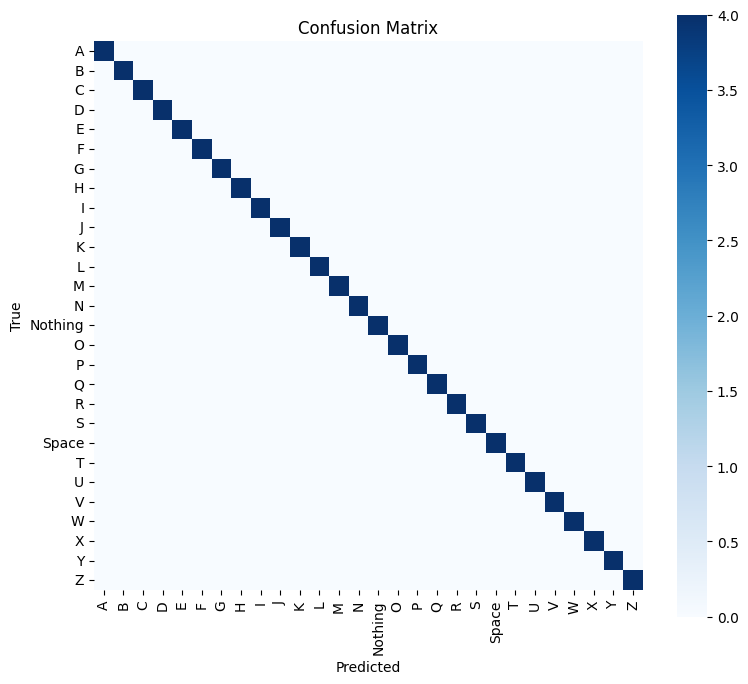

In [9]:
import torch, itertools
from torch.utils.data import DataLoader
from torchvision import datasets

device = 'cuda'

model = GFNet(
    img_size=96, patch_size=8, in_chans=1,
    num_classes=28, embed_dim=256, depth=8,
    drop_rate=0.2, drop_path_rate=0.1
).to(device)


ckpt_path = '/content/drive/MyDrive/3007/Archive/saved_models/gfnet_finetune_best.pt'
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print(f"Weights loaded from {ckpt_path}")

test_root = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Train'

test_ds = datasets.ImageFolder(test_root, transform=val_process)
test_loader = DataLoader(
    test_ds, batch_size=1024, shuffle=False,
    num_workers=8, pin_memory=True
)

total, correct = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_acc = correct / total
print(f"Test accuracy: {test_acc:.4%}  ({correct}/{total})")


import numpy as np, matplotlib.pyplot as plt, seaborn as sns
labels = torch.cat(all_labels)
preds = torch.cat(all_preds)

cm = torch.zeros(28, 28, dtype=torch.int32)
for t, p in zip(labels, preds):
    cm[t, p] += 1

plt.figure(figsize=(8, 7))
sns.heatmap(cm.numpy(), annot=False, cmap="Blues", square=True,
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [32]:
device = 'cuda'

root_train = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Train'
root_val = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Test'

train_ds = datasets.ImageFolder(root_train, transform=preprocess)
val_ds = datasets.ImageFolder(root_val, transform=val_process)

sampler = FewShotBalancedSampler(train_ds.targets, k_per_class=300,
                                 generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(
    train_ds, sampler=sampler, batch_size=512, num_workers=12,
    pin_memory=True, persistent_workers=True, prefetch_factor=4, drop_last=True
)
val_loader = DataLoader(
    val_ds, shuffle=False, batch_size=512, num_workers=12,
    pin_memory=True
)


model = GFNet(
    img_size=96, patch_size=8, in_chans=1, num_classes=28,
    embed_dim=256, depth=8, drop_rate=0.2, drop_path_rate=0.1
).to(device)



ckpt_path = '/content/drive/MyDrive/3007/Archive/saved_models/gfnet_interrupt.pt'
model.load_state_dict(torch.load(ckpt_path, map_location=device))


fine_lr = 1e-4                    # lower LR for polish
optimizer = torch.optim.AdamW(model.parameters(), lr=fine_lr,
                              weight_decay=1e-5, fused=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=15, eta_min=fine_lr/50
)
criterion  = nn.CrossEntropyLoss(label_smoothing=0.1)  # optional LS
amp_dtype  = torch.bfloat16

@torch.no_grad()
def evaluate():
    model.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    for x, y in val_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.amp.autocast(device_type='cuda', dtype=amp_dtype):
            logits = model(x)
            loss   = criterion(logits, y)
        preds  = logits.argmax(1)
        correct += (preds == y).sum().item()
        tot     += y.size(0)
        loss_sum += loss.item() * y.size(0)
    return loss_sum / tot, correct / tot


best_acc = 0.0
for epoch in range(1, 16):
    model.train()
    for xb, yb in tqdm(train_loader, desc=f'ep {epoch}', leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda', dtype=amp_dtype):
            loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    scheduler.step()

    v_loss, v_acc = evaluate()
    print(f'Epoch {epoch:02d}  val_acc={v_acc:.4%}  val_loss={v_loss:.4f}')

    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(model.state_dict(),
                   f'/content/drive/MyDrive/3007/Archive/saved_models/gfnet_finetune_best.pt')
    if v_acc >= 0.99:
        print('Reached 99stopping.')
        break

Epoch 01  val_acc=100.0000%  val_loss=1.0502
Reached 99stopping.


Weights loaded from /content/drive/MyDrive/3007/Archive/saved_models/gfnet_finetune_best.pt
Total test dataset size: 165670
Number of classes: 28
Creating balanced subset...
Class 0 (A): 1000 samples
Class 1 (B): 1000 samples
Class 2 (C): 1000 samples
Class 3 (D): 1000 samples
Class 4 (E): 1000 samples
Class 5 (F): 1000 samples
Class 6 (G): 1000 samples
Class 7 (H): 1000 samples
Class 8 (I): 1000 samples
Class 9 (J): 1000 samples
Class 10 (K): 1000 samples
Class 11 (L): 1000 samples
Class 12 (M): 1000 samples
Class 13 (N): 1000 samples
Class 14 (Nothing): 1000 samples
Class 15 (O): 1000 samples
Class 16 (P): 1000 samples
Class 17 (Q): 1000 samples
Class 18 (R): 1000 samples
Class 19 (S): 1000 samples
Class 20 (Space): 1000 samples
Class 21 (T): 1000 samples
Class 22 (U): 1000 samples
Class 23 (V): 1000 samples
Class 24 (W): 1000 samples
Class 25 (X): 1000 samples
Class 26 (Y): 1000 samples
Class 27 (Z): 1000 samples
Subset size: 28000 (expected: 5600 = 5600)
Starting inference on subse

<ipython-input-47-0b2bda4e0b6c>:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Processed batch 0/55 - Running accuracy: 86.9141%
Processed batch 5/55 - Running accuracy: 95.1172%
Processed batch 10/55 - Running accuracy: 96.5376%
Processed batch 15/55 - Running accuracy: 97.1313%
Processed batch 20/55 - Running accuracy: 97.7586%
Processed batch 25/55 - Running accuracy: 97.2656%
Processed batch 30/55 - Running accuracy: 97.4168%
Processed batch 35/55 - Running accuracy: 97.4447%
Processed batch 40/55 - Running accuracy: 96.6273%
Processed batch 45/55 - Running accuracy: 96.5056%
Processed batch 50/55 - Running accuracy: 96.5456%

Final Test accuracy on subset: 96.7714% (27096/28000)
Computing confusion matrix

Class distribution in subset:
Class 0 (A): 1000 samples
Class 1 (B): 1000 samples
Class 2 (C): 1000 samples
Class 3 (D): 1000 samples
Class 4 (E): 1000 samples
Class 5 (F): 1000 samples
Class 6 (G): 1000 samples
Class 7 (H): 1000 samples
Class 8 (I): 1000 samples
Class 9 (J): 1000 samples
Class 10 (K): 1000 samples
Class 11 (L): 1000 samples
Class 12 (M): 

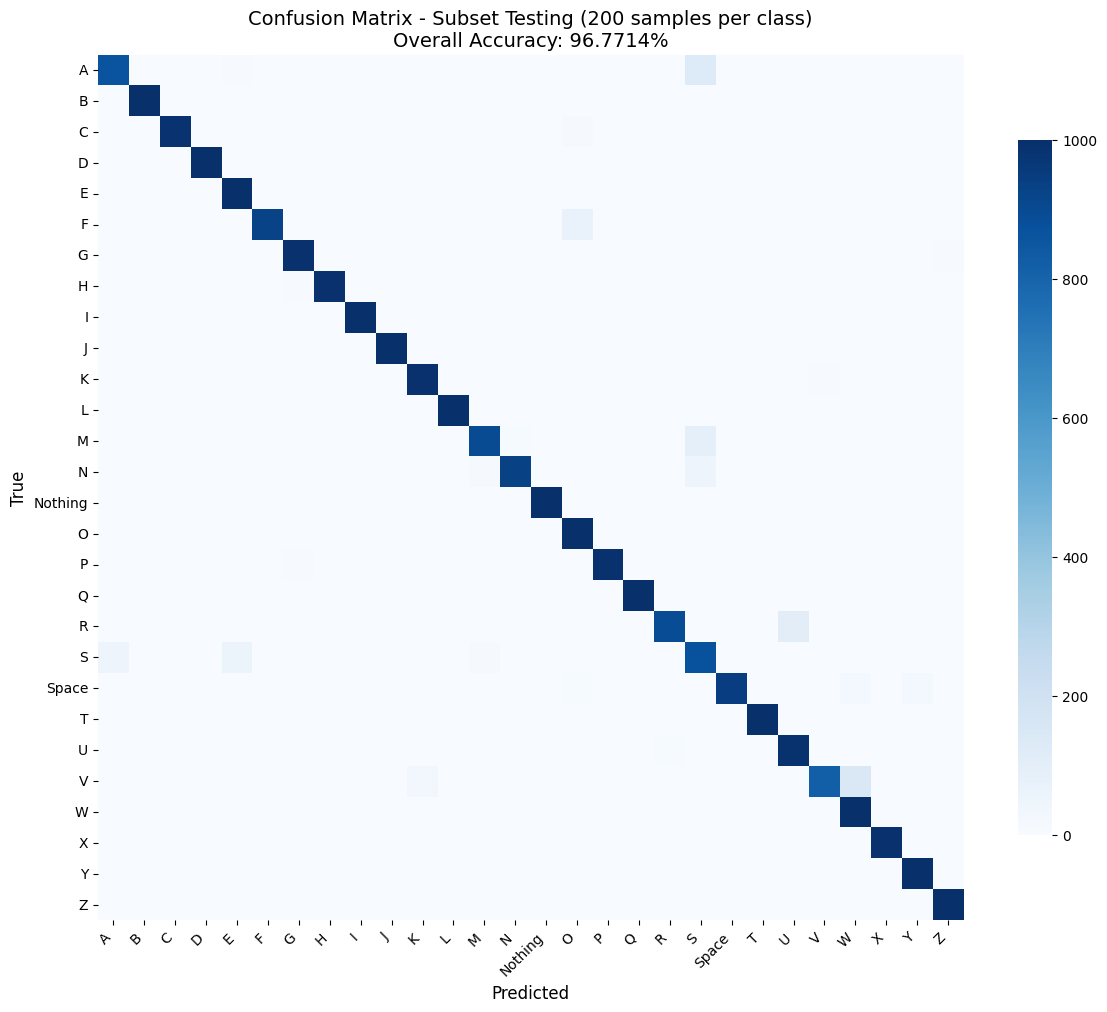

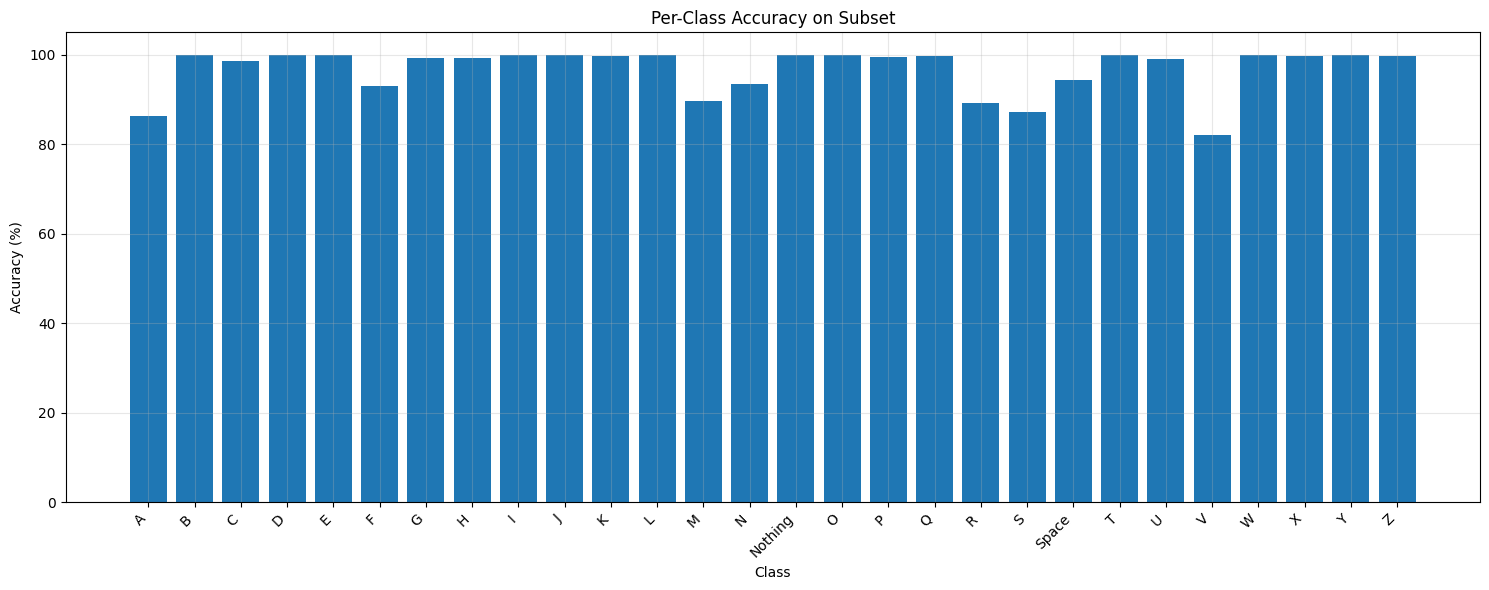

Inference completed!


In [47]:
import torch
import itertools
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

root_val = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Train'
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = 'cuda'

# Load model (assuming GFNet and val_process are already defined)
model = GFNet(
    img_size=96, patch_size=8, in_chans=1,
    num_classes=28, embed_dim=256, depth=8,
    drop_rate=0.2, drop_path_rate=0.1
).to(device)

ckpt_path = '/content/drive/MyDrive/3007/Archive/saved_models/gfnet_finetune_best.pt'
state_dict = torch.load(ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()
print(f"Weights loaded from {ckpt_path}")

model = model.half()

test_root = '/content/drive/MyDrive/3007/Archive/ASL_Dataset/Train'

# Create full test dataset
test_ds = datasets.ImageFolder(test_root, transform=val_process)
print(f"Total test dataset size: {len(test_ds)}")
print(f"Number of classes: {len(test_ds.classes)}")

# Create balanced subset (200 samples per class) - FAST VERSION
def create_balanced_subset_fast(dataset, samples_per_class=5):
    """Create a balanced subset using dataset.samples directly - much faster!"""
    # Get all file paths and their labels from ImageFolder
    samples = dataset.samples  # List of (path, class_index) tuples

    # Group indices by class using the pre-computed labels
    class_indices = defaultdict(list)
    for idx, (path, label) in enumerate(samples):
        class_indices[label].append(idx)

    # Sample indices for each class
    subset_indices = []
    for class_label, indices in class_indices.items():
        # Shuffle and take first samples_per_class samples
        random.shuffle(indices)
        selected_indices = indices[:samples_per_class]
        subset_indices.extend(selected_indices)
        print(f"Class {class_label} ({dataset.classes[class_label]}): {len(selected_indices)} samples")

    return subset_indices

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("Creating balanced subset...")
subset_indices = create_balanced_subset_fast(test_ds, samples_per_class=1000)
test_subset = Subset(test_ds, subset_indices)

print(f"Subset size: {len(test_subset)} (expected: {28 * 200} = {28 * 200})")

# Optimized DataLoader settings
test_loader = DataLoader(
    test_subset,  # Use subset instead of full dataset
    batch_size=512,  # Reduced batch size for subset
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=False,
)

total, correct = 0, 0
all_preds, all_labels = [], []

# Main inference loop with optimizations
print("Starting inference on subset")
with torch.no_grad(), torch.cuda.amp.autocast():
    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.to(device, non_blocking=True, dtype=torch.half)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        preds = logits.argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        # Move to CPU efficiently
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

        if batch_idx % 5 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)} - Running accuracy: {correct/total:.4%}")

test_acc = correct / total
print(f"\nFinal Test accuracy on subset: {test_acc:.4%} ({correct}/{total})")

# Efficient confusion matrix computation
print("Computing confusion matrix")
labels = torch.cat(all_labels)
preds = torch.cat(all_preds)

# Verify class distribution in subset
unique_labels, counts = torch.unique(labels, return_counts=True)
print("\nClass distribution in subset:")
for label, count in zip(unique_labels, counts):
    print(f"Class {label} ({test_ds.classes[label]}): {count} samples")

# Vectorized confusion matrix computation
n_classes = 28
cm = torch.bincount(
    n_classes * labels + preds,
    minlength=n_classes**2
).reshape(n_classes, n_classes)

# Calculate per-class accuracy
class_accuracies = cm.diag() / cm.sum(1)
print(f"\nPer-class accuracies:")
for i, acc in enumerate(class_accuracies):
    print(f"{test_ds.classes[i]}: {acc:.4%}")

print(f"Mean per-class accuracy: {class_accuracies.mean():.4%}")

# Plotting confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm.numpy(),
    annot=False,
    fmt='d',
    cmap="Blues",
    square=True,
    xticklabels=test_ds.classes,
    yticklabels=test_ds.classes,
    cbar_kws={'shrink': 0.8}
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix - Subset Testing (200 samples per class)\nOverall Accuracy: {test_acc:.4%}", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot per-class accuracy
plt.figure(figsize=(15, 6))
class_names = [name.replace('_', ' ') for name in test_ds.classes]
plt.bar(range(len(class_accuracies)), class_accuracies.numpy() * 100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy on Subset')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
print("Inference completed!")